In [5]:
import pickle
import os
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from functools import reduce

In [23]:
# change if required
lmbda = [0.001]
rnd_seed = 2345
modelversion = "avg-ID-jointly"
l_n = [4]

In [49]:
all_dirs = []
l_all_results = []
l_all_models = []

for n in l_n:
    for la in lmbda:
        results_dir_ID = os.path.join("./results", modelversion, f'{n}d', str(la), f'seed{rnd_seed}')
        all_dirs.append(results_dir_ID)
for d in all_dirs:
    file_path = os.path.join(d, 'results.json')
    if os.path.isfile(file_path):
        with open(file_path, "r") as f:
            l_results = json.load(f)
            l_all_results.append(l_results)
        p = os.path.join(d, "model", 'model_epoch0004.tar')
        m = torch.load(p, weights_only=True)
        l_all_models.append(m)
    else:
        print("not found")

In [53]:
df_train_eval = pd.DataFrame({
    "train_acc": l_all_models[0]["train_accs"],
    "val_acc": l_all_models[0]["val_accs"]
})

In [54]:
df_train_eval

,train_acc,val_acc
0,0.434700,0.445931
1,0.448181,0.445271
2,0.449568,0.444195
3,0.451115,0.446449


In [45]:
l_eval = []

for id, all_results in enumerate(l_all_results):
    val_acc_avg = np.array([l[1] for l in all_results["l_val_avg"]])
    val_acc_ID = np.array([l[1] for l in all_results["l_val_ID"]])
    n_dim = all_results["l_train_ID"][0]["ics"].shape[0]
    l_n_data_train = []
    l_n_data_eval = []
    for subj in all_results["l_train_ID"]:
        train_accs = np.array(subj["train_accs"])
        df_train = pd.DataFrame({
            "ID": np.arange(0, train_accs.shape[0]),  
            "n_dim": np.repeat(n_dim, train_accs.shape[0]), 
            "epoch": np.arange(0, train_accs.shape[0]),
            "train_acc": train_accs
        })
        l_train.append(df_train)
        l_n_data_train.append(subj["n_choices_train"])
        l_n_data_eval.append(subj["n_choices_test"])
    n_data_train = np.array(l_n_data_train)
    n_data_eval = np.array(l_n_data_eval)
    df_eval = pd.DataFrame({
        "ID": np.arange(0, val_acc_avg.shape[0]),  
        "n_dim": np.repeat(n_dim, val_acc_avg.shape[0]), 
        "val_acc_avg": val_acc_avg, "val_acc_ID": val_acc_ID,
        "n_data_train": n_data_train,
        "n_data_eval": n_data_eval
    })
    l_eval.append(df_eval)

KeyError: 'l_val_avg'

In [431]:
dfs_eval = reduce(lambda left, right: pd.concat([left, right]), l_eval)
dfs_train = reduce(lambda left, right: pd.concat([left, right]), l_train)

In [432]:
dfs_eval["delta"] = dfs_eval["val_acc_ID"] - dfs_eval["val_acc_avg"]
# only required because bug in previous badge > 50
dfs_eval = dfs_eval.query("n_dim <= 50")

In [433]:
dfs_eval["delta"].count()

1584

In [434]:
dfs_eval.sort_values("n_data_train").head(150)

,ID,n_dim,val_acc_avg,val_acc_ID,n_data_train,n_data_eval,delta
138,138,30,0.600000,0.760000,208,52,1.600000e-01
65,65,5,0.560000,0.540000,208,52,-2.000004e-02
41,41,5,0.400000,0.420000,208,52,1.999998e-02
14,14,5,0.700000,0.680000,208,52,-1.999998e-02
65,65,40,0.560000,0.560000,208,52,0.000000e+00
...,...,...,...,...,...,...,...
221,221,5,0.453333,0.506667,384,96,5.333331e-02
263,263,50,0.546667,0.466667,384,96,-8.000001e-02
221,221,50,0.440000,0.520000,384,96,8.000001e-02
263,263,40,0.533333,0.533333,384,96,5.960464e-08


In [435]:
dfs_eval[["val_acc_avg", "val_acc_ID"]].mean()

val_acc_avg    0.614335
val_acc_ID     0.626748
dtype: float64

In [436]:
dfs_eval["n_dim"].count()

1584

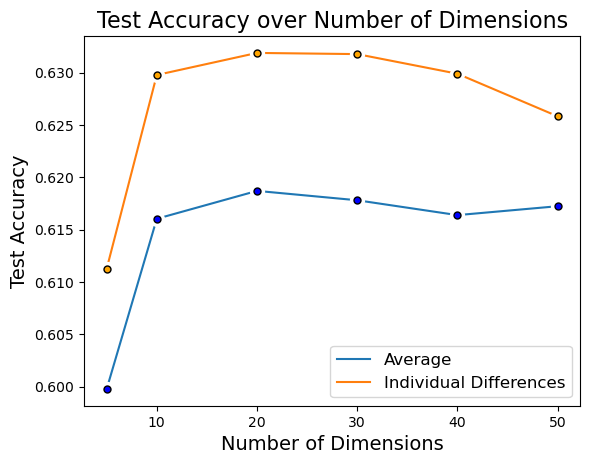

In [437]:
# Your existing plotting code 
ax = dfs_eval.groupby("n_dim")[["val_acc_avg", "val_acc_ID"]].mean().plot()
# Add intersection points with a larger circumference and white border 
for i, line in enumerate(ax.get_lines()):
    x_data = line.get_xdata() 
    y_data = line.get_ydata() 
    ax.scatter(x_data, y_data, color='white', edgecolor='white', s=100, zorder=3) # Adjust 's' for size
    ax.scatter(x_data, y_data, color=["blue", "orange"][i], edgecolor='black', s=25, zorder=4) # Adjust 's' for size
ax.set_xlabel('Number of Dimensions', fontsize=14) 
ax.set_ylabel('Test Accuracy', fontsize=14) 
ax.set_title('Test Accuracy over Number of Dimensions', fontsize=16) 
ax.legend(['Average', 'Individual Differences'], fontsize=12)
plt.show()

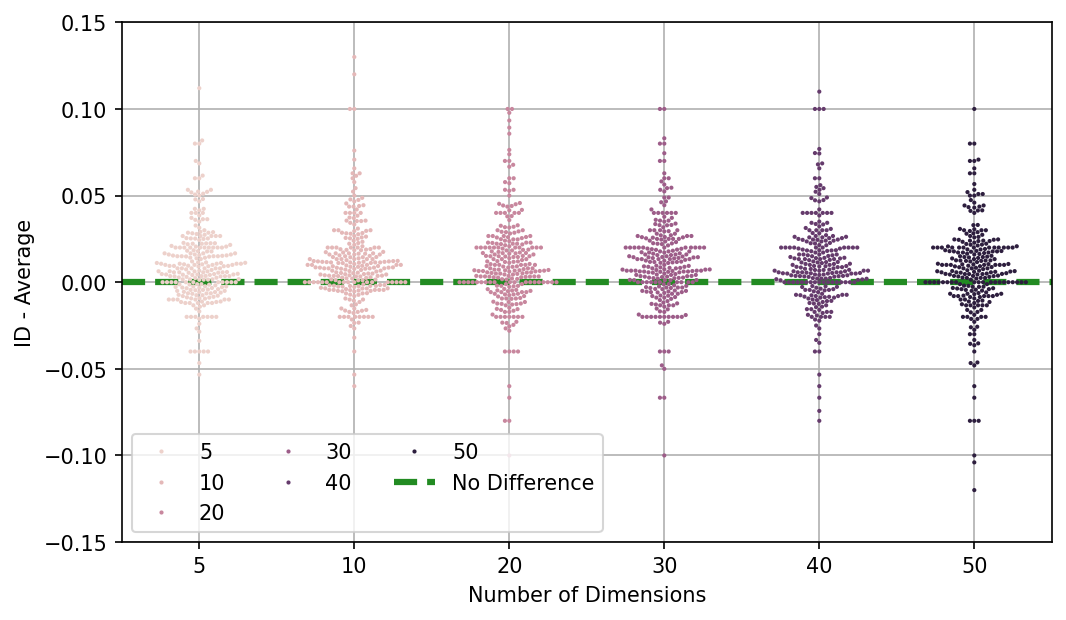

In [438]:
fig = plt.figure(figsize=(8, 4.5), dpi=150)
ax = plt.subplot(111)
sns.swarmplot(
    x="n_dim", y="delta", hue="n_dim", data=dfs_eval.reset_index(drop=True), 
    size=2
)
ax.axhline(y=0, color='forestgreen', linestyle='--', linewidth=3, label='No Difference')
ax.set_ylim(-.15, .15)
ax.set_ylabel("ID - Average")
ax.set_xlabel("Number of Dimensions")

ax.legend(loc=0, ncol = 3)
ax.grid(True)

In [439]:
dfs_eval.loc[:, "n_data_train_log"] = np.log(dfs_eval["n_data_train"])

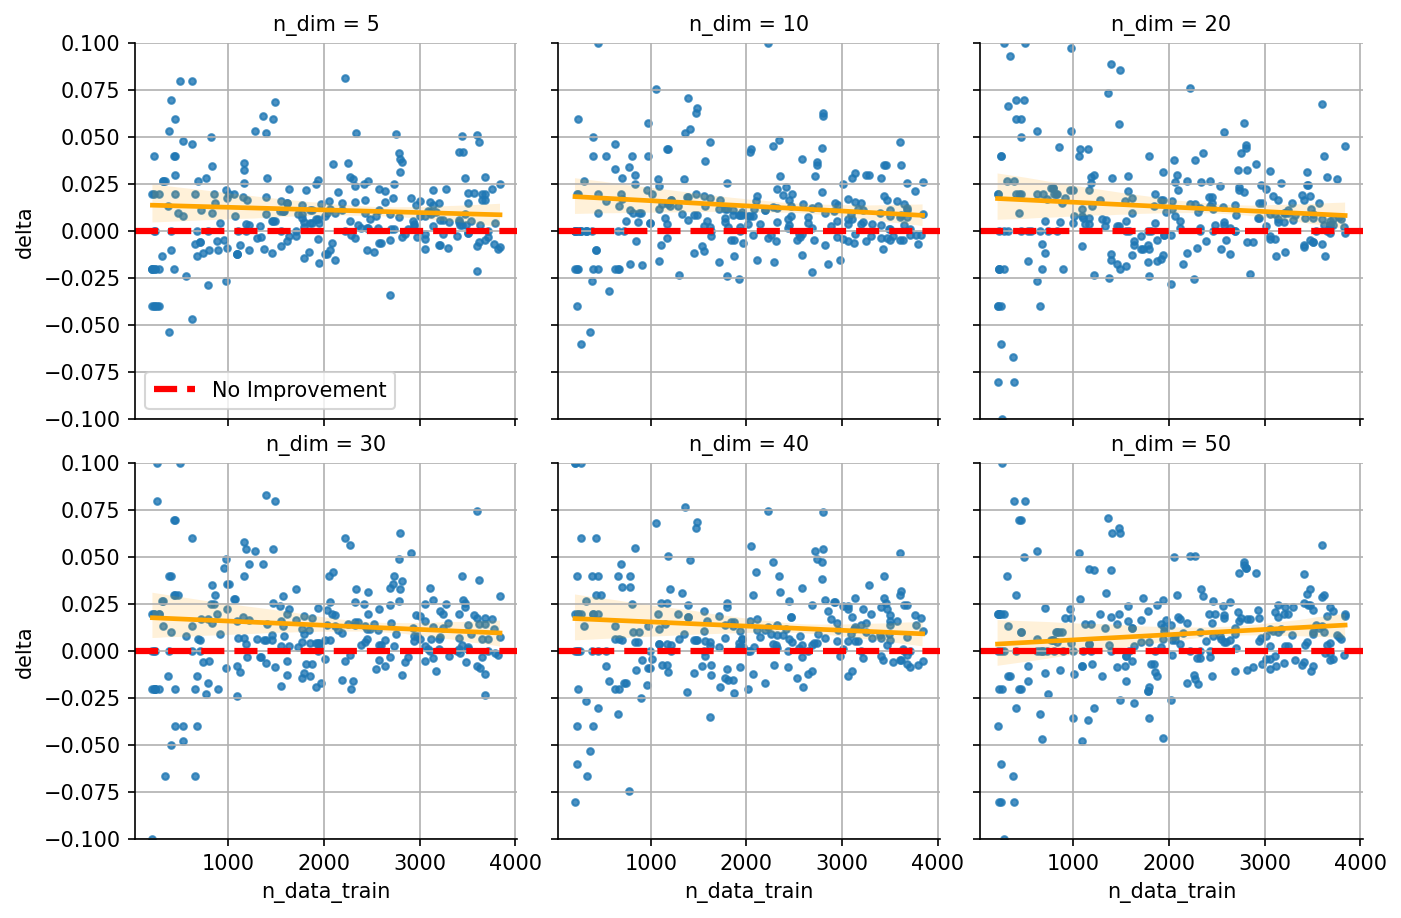

In [440]:
# Create the FacetGrid without specifying an external axis
g = sns.lmplot( data=dfs_eval, x='n_data_train', y='delta', col='n_dim', col_wrap=3, height=4, 
               # Adjust height for each facet 
               aspect=1, # Adjust aspect ratio 
               scatter_kws={'s': 10}, # Adjust the scatter plot marker size 
               line_kws={'color': 'orange'} # Adjust the regression line color 
              )
# Add gridlines to each facet 
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=3, label='No Improvement')
    #ax.set_xlim(0, 400)
    ax.set_ylim(-.1, .1)
    if i == 0:
        ax.legend()
    
# Adjust the plot size
g.fig.set_size_inches(9, 6)
g.fig.set_dpi(150)

plt.show()


In [320]:
dfs_eval.sort_values("delta", ascending=False)

,ID,n_dim,val_acc_avg,val_acc_ID,n_data_train,n_data_eval,delta,n_data_train_log
48,48,20,0.359286,0.547857,5984,1496,0.188571,8.696845
48,48,40,0.368571,0.547857,5984,1496,0.179286,8.696845
48,48,50,0.377857,0.554286,5984,1496,0.176429,8.696845
48,48,30,0.375000,0.550000,5984,1496,0.175000,8.696845
48,48,10,0.356429,0.512857,5984,1496,0.156429,8.696845
...,...,...,...,...,...,...,...,...
189,189,5,NaN,NaN,224,56,NaN,5.411646
190,190,5,NaN,NaN,208,52,NaN,5.337538
192,192,5,NaN,NaN,208,52,NaN,5.337538
196,196,5,NaN,NaN,352,88,NaN,5.863631


In [325]:
df_train.head()

,ID,n_dim,epoch,train_acc
0,0,90,0,0.4825
1,1,90,1,0.5050
2,2,90,2,0.4750
3,3,90,3,0.4900
4,4,90,4,0.5225


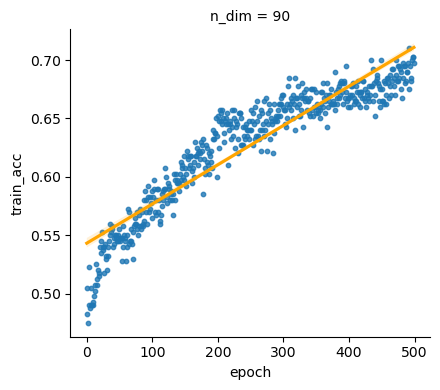

In [326]:
# Create the FacetGrid without specifying an external axis
g = sns.lmplot( data=df_train, x='epoch', y='train_acc', col='n_dim', col_wrap=3, height=4, 
               # Adjust height for each facet 
               aspect=1, # Adjust aspect ratio 
               scatter_kws={'s': 10}, # Adjust the scatter plot marker size 
               line_kws={'color': 'orange'} # Adjust the regression line color 
              )